Author: Tamanna Ananna
UNI: ta2642

In [1]:
!pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.2 MB/s 
     |████████████████████████████████| 1.6 MB 32.0 MB/s 


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

# Mount Google Drive

In [3]:
from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Mounted at /content/drive


In [33]:
# Set data file location

from pathlib import Path

DATA = Path("/content/drive/My Drive/2022 ECBM E4060/data")

In [86]:
training_data = "Training_data.csv"
train = pd.read_csv(DATA/training_data)
train.head()

,CELL_LINE_NAME,DRUG_NAME,KRT19,TGFBI,FN1,VIM,CD24P4,SPARC,S100A16,UCHL1,...,X92,X93,X94,X95,X96,X97,X98,X99,X100,LN_IC50
0,22RV1,5-Fluorouracil,8.042207,1.070389,3.344828,3.049631,3.942984,0.669027,0.871844,2.06695,...,-0.011703,-0.414060,0.061474,0.549070,-0.192303,0.185672,-0.128457,0.024697,0.263466,2.478859
1,22RV1,ABT737,8.042207,1.070389,3.344828,3.049631,3.942984,0.669027,0.871844,2.06695,...,-0.113681,0.204337,-0.150768,0.114594,-0.110021,0.197329,-0.206644,-0.351558,0.035348,3.748055
2,22RV1,Acetalax,8.042207,1.070389,3.344828,3.049631,3.942984,0.669027,0.871844,2.06695,...,0.079674,0.481107,-0.289358,0.153831,-0.011794,0.442237,-0.127095,-0.152633,0.010294,-0.933771
3,22RV1,Afatinib,8.042207,1.070389,3.344828,3.049631,3.942984,0.669027,0.871844,2.06695,...,-0.019880,0.096177,0.073550,0.238451,-0.160336,0.069875,-0.041842,-0.101994,0.249072,2.433064
4,22RV1,Afuresertib,8.042207,1.070389,3.344828,3.049631,3.942984,0.669027,0.871844,2.06695,...,-0.151985,0.201704,-0.057129,0.264910,-0.087108,0.127217,-0.096696,-0.103081,0.269846,1.463836


In [5]:
print(train.shape)

(80056, 603)


In [6]:
#train.iloc[:,2:-1] #second column to second to last
train.iloc[:,-1:] # LN_IC50

,LN_IC50
0,2.478859
1,3.748055
2,-0.933771
3,2.433064
4,1.463836
...,...
80051,5.864494
80052,5.534174
80053,6.484139
80054,4.432672


In [7]:
train.columns[0]

'CELL_LINE_NAME'

In [8]:
CL = train['CELL_LINE_NAME'].unique()
print('unique cell lines: ', len(CL))

unique cell lines:  550


In [9]:
DN = train['DRUG_NAME'].unique()
print('unique drugs: ', len(DN))

unique drugs:  173


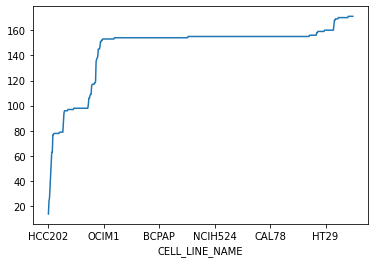

In [10]:
train.groupby('CELL_LINE_NAME').size().sort_values().plot()

## Create model & test

List of hyper parameters:

- First Dropout percentage- 0.1 to 0.5
- Number of layers, from 2 to 6
- Dense layer number of units from 128 to 256 **changed step size**
- learning rate



```
hp.Int('name', min_value = 32, max_value = 512, step = 128)```



In [ ]:
from kerastuner.tuners import RandomSearch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [ ]:
##Defining hyper parameters
layers_range = (2, 6)
units_range = (128, 256, 32)
lr_values = [1e-3, 1e-4, 1e-5]

In [ ]:
directory = Path("/content/drive/My Drive/2022 ECBM E4060/log")
project_name = 'Genes'

## MODEL WITH HYPER PARAME

In [ ]:
#define model building function with hyper parameter function hp as input
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(600, input_dim=600, activation='relu'))
  model.add(keras.layers.Dense(units=512, activation='relu'))
  #adds dropout layer- hyperparam- tries from 10 to 50%
  model.add(keras.layers.Dropout(
            hp.Float(
                'dropout',
                min_value=0.1,
                max_value=0.5,
                default=0.1,
                step=0.1)))
  for i in range(hp.Int('layers', 2,6)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                  min_value=128, max_value=256,
                                                  step=32), activation='relu'))
        model.add(
            keras.layers.Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.1,
                    max_value=0.5,
                    default=0.1,
                    step=0.1)
            )
        )

  model.add(keras.layers.Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=lr_values)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error')
  return model

In [ ]:
#hyperparam- objective is val loss
k = 5
for i in range(0,k):
  #get the kfold cell lines
  val_CL_kfold = train_CL[(i*fold_len) : (i+1)*fold_len]
  train_CL_kfold = list(set(train_CL) - set(val_CL_kfold))
  
  #get the subset from df
  train_df = train[train['CELL_LINE_NAME'].isin(train_CL_kfold)]
  val_df = train[train['CELL_LINE_NAME'].isin(val_CL_kfold)]

  #prepare for model
  X_train = train_df.iloc[:, 2:-1]
  y_train = train_df['LN_IC50']
  X_val = val_df.iloc[:, 2:-1]
  y_val = val_df['LN_IC50']
  
  tuner = kt.Hyperband(build_model,  # the hypermodel
                         objective='val_loss',  # objective to optimize
                         max_epochs=30,
                         factor=3,
                         directory=directory,  # directory to save logs
                         project_name=project_name + str(i + 1)) #saves weights

  stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  
  #basically works as model.fit
  tuner.search(X_train, y_train, epochs=30, 
             validation_data=(X_val, y_val), 
             callbacks=[stop_early])
    
  best_hp = tuner.get_best_hyperparameters()[0]
  best_model = tuner.get_best_models()[0]

# Build the model with the optimal hyperparameters
  h_model = tuner.hypermodel.build(best_hp)
  h_model.fit(X_train, y_train, epochs=50, verbose=1, batch_size=128, validation_data=(X_val, Y_val))
  h_model.save('precily_cv_' + str(i + 1) + '.hdf5')
  h_model = None


Trial 22 Complete [00h 01m 23s]
val_loss: 4.711125373840332

Best val_loss So Far: 4.521739959716797
Total elapsed time: 00h 25m 26s

Search: Running Trial #23

Value             |Best Value So Far |Hyperparameter
0.5               |0.1               |dropout
4                 |3                 |layers
256               |160               |units_0
160               |192               |units_1
1e-05             |0.001             |learning_rate
160               |224               |units_2
192               |128               |units_3
128               |160               |units_4
192               |160               |units_5
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
1784/1784 [==============================] - 29s 16ms/step - loss: 18.3573 - val_loss: 9.3467
Epoch 2/2
 419/1784 [======>.......................

KeyboardInterrupt: ignored

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}


## Fit model

In [ ]:
train_final_df = train[train['CELL_LINE_NAME'].isin(train_CL)]
X_train = train_final_df.iloc[:, 2:-1]
y_train = train_final_df['LN_IC50']

In [ ]:
i =0
h_model = tf.keras.models.load_model('precily_cv_' + str(i + 1) + '.hdf5')
h_model.fit(X_train, y_train, verbose=1, epochs=50, batch_size=128)
h_model.save('Model' + str(i + 1) + '.hdf5')

OSError: ignored

In [ ]:
X_test = test_set_df.iloc[:, 2:-1]
y_test = test_set_df['LN_IC50']

In [ ]:
y_pred = h_model.predict(X_test)

In [ ]:
#cor(y_test, y_pred)
#pearson correlation
from scipy.stats import pearsonr

#covariance(X, Y) / (stdv(X) * stdv(Y))
corr, _ = pearsonr(y_pred, y_test)
print('Pearsons correlation: %.3f' % corr)

## BASELINE MODEL

In [6]:
#read test data
import requests
import io

# Downloading the csv file 
 
url = "https://raw.githubusercontent.com/SmritiChawla/Precily/main/Fig1/Fig1c/Fig1c_Precily_genes/Test_data.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
test = pd.read_csv(io.StringIO(download.decode('utf-8')))

# Printing out the first 5 rows of the dataframe

#print (test.head())

X_test = test.iloc[:, 2:-1]
y_test = test.iloc[:,-1]
print('xtest shape: ', X_test.shape)
print('ytest shape: ', y_test.shape)

xtest shape:  (8008, 600)
ytest shape:  (8008,)


In [35]:
#save test 
from pathlib import Path

DATA = Path("/content/drive/My Drive/2022 ECBM E4060/data")

test.to_csv(DATA/'Test_data.csv')

In [163]:
X_train = train.iloc[:, 2:-1]
y_train = train['LN_IC50']
print('xtrain shape: ', X_train.shape)
print('ytrain shape: ', y_train.shape)

xtrain shape:  (80056, 600)
ytrain shape:  (80056,)


In [7]:
#55 genes
test['0'].unique().shape
test['1'].unique().shape #173 drugs

(173,)

In [82]:
def build_model():
  model = keras.Sequential()
  model.add(keras.layers.Dense(600, input_dim=600, activation='relu'))
  model.add(keras.layers.Dense(units=512, activation='relu'))
  #adds dropout layer- hyperparam- tries from 10 to 50%
  model.add(keras.layers.Dropout(0.1))
  model.add(keras.layers.Dense(units=256, activation='relu'))
  model.add(keras.layers.Dropout(0.1))
  model.add(keras.layers.Dense(units=128, activation='relu'))
  model.add(keras.layers.Dropout(0.1))
  model.add(keras.layers.Dense(1))
  return model

In [79]:
def compile_model(model, learning_rate = 0.0001):
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_absolute_error')
  return model

In [174]:
#callback = tf.keras.callbacks.EarlyStopping(patience=5)
#callbacks=[callback]

model = build_model()
model = compile_model(model)
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 600)               360600    
                                                                 
 dense_40 (Dense)            (None, 512)               307712    
                                                                 
 dropout_22 (Dropout)        (None, 512)               0         
                                                                 
 dense_41 (Dense)            (None, 256)               131328    
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_42 (Dense)            (None, 128)               32896     
                                                                 
 dropout_24 (Dropout)        (None, 128)              

In [175]:
%%time
history = model.fit(X_train, y_train, 
                    batch_size = 128, epochs=20,
                    verbose= 0)
train_loss = history.history['loss']

print('Train loss %.3f' %train_loss[-1])


Train loss 1.264
CPU times: user 7min 49s, sys: 22.4 s, total: 8min 12s
Wall time: 4min 49s


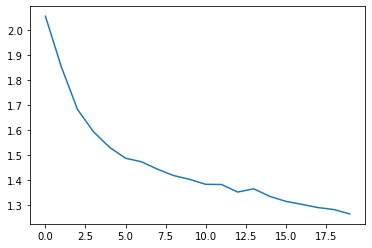

In [176]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')

In [177]:
y_pred = model.predict(X_test)
y_pred_flat = y_pred.flatten().tolist()

251/251 [==============================] - 2s 6ms/step


In [178]:
test_loss = model.evaluate(X_test, y_test, verbose= 0)
print('Test loss %.3f' %test_loss)

Test loss 1.230


In [105]:
model_location = '/content/drive/My Drive/2022 ECBM E4060/models/'+'Model' + str(1) + '.hdf5'

model = tf.keras.models.load_model(model_location)

In [154]:
# save model
model.save('/content/drive/My Drive/2022 ECBM E4060/models/'+'Model' + str(4) + '.hdf5')

In [179]:
from scipy.stats import pearsonr

pearson, r = pearsonr(y_test, y_pred_flat)
print('pearson:' , pearson)

from sklearn.metrics import r2_score

r2 = r2_score(y_test,y_pred_flat)
print('r2: ' , r2)

from scipy.stats import ttest_ind
s, pvalue = ttest_ind(y_test, y_pred.flatten().tolist())
print("pvalue: {:.2E}".format(pvalue))

#linear fit line
m, b = np.polyfit(y_test, y_pred,1)

pearson: 0.8193031444146488
r2:  0.635871494019163
pvalue: 2.26E-28


For a global picture, we pooled our predictions across drugs and cell lines and obtained a Pearson’s correlation coefficient value of 0.88 (R2 = 0.77; P-value < 2.2e-16) (Fig. 1d).

<ipython-input-130-a8648a1be851>:14: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  s = a.scatter(


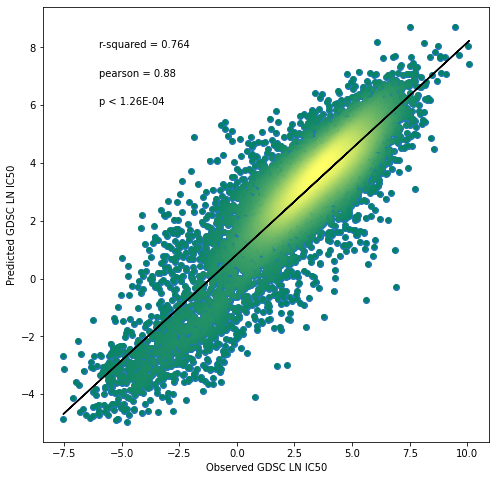

In [130]:
from scipy.stats import gaussian_kde
# initial data
x = y_test
y = pd.Series(y_pred_flat)

f, a = plt.subplots(figsize=(8,8))
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy) 
# Sort the points by density, so that the densest points are       
# plotted last                                                     
idx = z.argsort()

x2, y2, z = x[idx], y[idx], z[idx]                                 
s = a.scatter(                                                     
    x2, y2, c=z, s=25, cmap= 'summer', 
    edgecolor='', label=None, picker=True, zorder=2                
) 

plt.scatter(y_test, y_pred)
plt.xlabel('Observed GDSC LN IC50')
plt.ylabel('Predicted GDSC LN IC50')
plt.plot(y_test, m*y_test+b, color = "black")
plt.annotate("r-squared = {:.3f}".format(r2), (-6, 8))
plt.annotate("pearson = {:.2f}".format(pearson), (-6, 7))
plt.annotate("p < {:.2E}".format(pvalue), (-6, 6))
plt.show()

### prediction value for each drug

- for each drug
- get the subset of data for the drug
- make predictions
- average out the predicted values
- calculate cor between true and prediction for all the data for that drug
- bind all, getting correlation value for each drug
-mean correlation at the end

In [10]:
drugs = test['1'].unique()
print(len(drugs))

## Hyperparameter tuning with five fold cross validation

### Train and test cell-line set split

In [87]:
#shuffle the cell line list
CL = train['CELL_LINE_NAME'].unique()

np.random.shuffle(CL)
train_CL = CL[:int(len(CL)*0.9)]
test_CL = CL[int(len(CL)*0.9):]

In [17]:
#test set df
test_set_df = train[train['CELL_LINE_NAME'].isin(test_CL)].copy()

In [ ]:
#model set- create k fold validation

def get_data():
  k = 3

  fold_len = len(train_CL)//k

  for i in range(0,k):
    #get the kfold cell lines
    val_CL_kfold = train_CL[(i*fold_len) : (i+1)*fold_len]
    train_CL_kfold = list(set(train_CL) - set(val_CL_kfold))
    
    #get the subset from df
    train_df = train[train['CELL_LINE_NAME'].isin(train_CL_kfold)]
    val_df = train[train['CELL_LINE_NAME'].isin(val_CL_kfold)]

    #prepare for model
    X_train = train_df.iloc[:, 2:-1]
    y_train = train_df['LN_IC50']
    X_val = val_df.iloc[:, 2:-1]
    y_val = val_df['LN_IC50']



In [88]:
#define hyper-parameter search space
learning_rates = [0.001]
hyperparams = {'learning_rate': learning_rates}
summary = []
train_losses = []
test_losses= []

k = 3
fold_len = len(train_CL)//k

#choose a hyper-parameter
for key, values in hyperparams.items():
  print(key)
  for val in values:
    
    train_losses = []
    test_losses= []

    for i in range(0,k):
      #get the kfold cell lines
      val_CL_kfold = train_CL[(i*fold_len) : (i+1)*fold_len]
      train_CL_kfold = list(set(train_CL) - set(val_CL_kfold))
      
      #get the subset from df
      train_df = train[train['CELL_LINE_NAME'].isin(train_CL_kfold)]
      val_df = train[train['CELL_LINE_NAME'].isin(val_CL_kfold)]

      #prepare for model
      X_train = train_df.iloc[:, 2:-1]
      y_train = train_df['LN_IC50']
      X_val = val_df.iloc[:, 2:-1]
      y_val = val_df['LN_IC50']
  

      #build & compile model
      model = build_model()
      model = compile_model(model, learning_rate = val)

      #fit model
      history = model.fit(X_train, y_train, 
                    batch_size = 128, epochs=20,
                    verbose= 0)
      train_loss = history.history['loss']
      test_loss = model.evaluate(X_val, y_val, verbose= 0)
      print(train_loss, test_loss)
      
      train_losses.append(train_loss)
      test_losses.append(test_loss)

      
    train_loss = np.mean(train_losses)
    test_loss = np.mean(test_losses)

    summary.append([key, val, train_loss, test_loss])

learning_rate
[2.1069071292877197, 1.8220497369766235, 1.6626132726669312, 1.6027398109436035, 1.5529927015304565, 1.5110098123550415, 1.4742236137390137, 1.4544123411178589, 1.428556203842163, 1.4044861793518066, 1.3932820558547974, 1.3564965724945068, 1.3709852695465088, 1.310178518295288, 1.3187144994735718, 1.2854211330413818, 1.2690141201019287, 1.2550182342529297, 1.2276008129119873, 1.2025035619735718] 1.6263909339904785
[2.1148526668548584, 1.8256248235702515, 1.676527976989746, 1.5911825895309448, 1.5491222143173218, 1.517298936843872, 1.4639734029769897, 1.4773623943328857, 1.4424971342086792, 1.4272011518478394, 1.4153194427490234, 1.3790369033813477, 1.3727611303329468, 1.353004813194275, 1.3290098905563354, 1.3058927059173584, 1.2936466932296753, 1.269264817237854, 1.245912790298462, 1.2886921167373657] 1.5803593397140503
[2.1238811016082764, 1.8342106342315674, 1.7120236158370972, 1.6114344596862793, 1.5397753715515137, 1.5224549770355225, 1.4929938316345215, 1.4584277868

In [ ]:
#build model

#compile model

#fit model
history = model.fit(X_train, y_train, 
                    batch_size = 128, epochs=20,
                    verbose= 0)
train_loss = history.history['loss']
test_loss = model.evaluate(X_test, y_test, verbose= 0)


## Loading Precily Gene models, Pearson correlation

In [17]:
model_location = '/content/drive/My Drive/2022 ECBM E4060/models/'

#model_1 = tf.keras.models.load_model(model_location+ 'Model' + str(1) + '.hdf5')
#model_2 = tf.keras.models.load_model(model_location+ 'Model' + str(2) + '.hdf5')
model_1 = tf.keras.models.load_model(model_location+ 'PrecilyModel' + str(1) + '.hdf5')
model_2 = tf.keras.models.load_model(model_location+ 'PrecilyModel' + str(1) + '.hdf5')
model_3 = tf.keras.models.load_model(model_location+ 'PrecilyModel' + str(1) + '.hdf5')
model_4 = tf.keras.models.load_model(model_location+ 'PrecilyModel' + str(1) + '.hdf5')
model_5 = tf.keras.models.load_model(model_location+ 'PrecilyModel' + str(1) + '.hdf5')



In [ ]:
from scipy.stats import pearsonr

cors = []
for d in drugs:
  #get subset of data for each drug
  subset = test.loc[test['1'] == d]
  X_test_d = subset.iloc[:, 2:-1]
  y_test_d = subset.iloc[:,-1]

  #make predictions
  y_pred_1 = model_1.predict(X_test_d, verbose = 0)
  y_pred_2 = model_2.predict(X_test_d, verbose = 0)
  y_pred_3 = model_3.predict(X_test_d, verbose = 0)
  y_pred_4 = model_4.predict(X_test_d, verbose = 0)
  y_pred_5 = model_5.predict(X_test_d, verbose = 0)

  #average prediciton for each model
  y_pred_mean = np.mean((y_pred_1.flatten().tolist(), 
                         y_pred_2.flatten().tolist(),
                         y_pred_3.flatten().tolist(),
                         y_pred_4.flatten().tolist(),
                         y_pred_5.flatten().tolist()), axis = 0)


  #correlation between true and observed
  r, p = pearsonr(y_test_d, y_pred_mean)
  cors.append(r)

In [57]:
print(sum(cors)/len(cors))
print(np.mean(cors))

0.23138807912673173
0.23138807912673165


In [62]:
precily_genes = pd.DataFrame(cors)
precily_genes.to_csv(DATA/'correlations_precily_genes.csv')

In [142]:
cors = []
for d in drugs:
  subset = test.loc[test['1'] == d]
  X_test_d = subset.iloc[:, 2:-1]
  y_test_d = subset.iloc[:,-1]

  y_pred_1 = model_1.predict(X_test_d)
  y_pred_2 = model_2.predict(X_test_d)

  y_pred_mean = np.mean((y_pred_1, y_pred_2), axis = 0)

  r, p = pearsonr(y_test_d, y_pred_mean)
  cors.append(r)

print(sum(cors)/len(cors))

array([0.658603902685222], dtype=object)

## Loading Precily Pathways models, getting correlation value

In [65]:
test_data = "Test_Set.csv"
test_data = pd.read_csv(DATA/test_data)
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431
0,22RV1,5-Fluorouracil,-0.033926,0.61844,-0.123854,0.421681,0.025471,-0.15411,0.495994,0.278725,...,-0.011703,-0.414060,0.061474,0.549070,-0.192303,0.185672,-0.128457,0.024697,0.263466,2.478859
1,22RV1,ABT737,-0.033926,0.61844,-0.123854,0.421681,0.025471,-0.15411,0.495994,0.278725,...,-0.113681,0.204337,-0.150768,0.114594,-0.110021,0.197329,-0.206644,-0.351558,0.035348,3.748055
2,22RV1,Acetalax,-0.033926,0.61844,-0.123854,0.421681,0.025471,-0.15411,0.495994,0.278725,...,0.079674,0.481107,-0.289358,0.153831,-0.011794,0.442237,-0.127095,-0.152633,0.010294,-0.933771
3,22RV1,Afatinib,-0.033926,0.61844,-0.123854,0.421681,0.025471,-0.15411,0.495994,0.278725,...,-0.019880,0.096177,0.073550,0.238451,-0.160336,0.069875,-0.041842,-0.101994,0.249072,2.433064
4,22RV1,Afuresertib,-0.033926,0.61844,-0.123854,0.421681,0.025471,-0.15411,0.495994,0.278725,...,-0.151985,0.201704,-0.057129,0.264910,-0.087108,0.127217,-0.096696,-0.103081,0.269846,1.463836


In [68]:
model_location = '/content/drive/My Drive/2022 ECBM E4060/model/'

#model_1 = tf.keras.models.load_model(model_location+ 'Model' + str(1) + '.hdf5')
#model_2 = tf.keras.models.load_model(model_location+ 'Model' + str(2) + '.hdf5')
model_1 = tf.keras.models.load_model(model_location+ 'PrecilyPathwayModel' + str(1) + '.hdf5')
model_2 = tf.keras.models.load_model(model_location+ 'PrecilyPathwayModel' + str(1) + '.hdf5')
model_3 = tf.keras.models.load_model(model_location+ 'PrecilyPathwayModel' + str(1) + '.hdf5')
model_4 = tf.keras.models.load_model(model_location+ 'PrecilyPathwayModel' + str(1) + '.hdf5')
model_5 = tf.keras.models.load_model(model_location+ 'PrecilyPathwayModel' + str(1) + '.hdf5')


In [ ]:
from scipy.stats import pearsonr

cors = []
for d in drugs:
  #get subset of data for each drug
  subset = test_data.loc[test_data['1'] == d]
  X_test_d = subset.iloc[:, 2:-1]
  y_test_d = subset.iloc[:,-1]

  #make predictions
  y_pred_1 = model_1.predict(X_test_d, verbose = 0)
  y_pred_2 = model_2.predict(X_test_d, verbose = 0)
  y_pred_3 = model_3.predict(X_test_d, verbose = 0)
  y_pred_4 = model_4.predict(X_test_d, verbose = 0)
  y_pred_5 = model_5.predict(X_test_d, verbose = 0)

  #average prediciton for each model
  y_pred_mean = np.mean((y_pred_1.flatten().tolist(), 
                        y_pred_2.flatten().tolist(),
                        y_pred_3.flatten().tolist(),
                        y_pred_4.flatten().tolist(),
                        y_pred_5.flatten().tolist()), axis = 0)


  #correlation between true and observed
  r, p = pearsonr(y_test_d, y_pred_mean)
  cors.append(r)

In [70]:
print(np.mean(cors))

0.4739690173467575


In [71]:
#output as csv
precily_path = pd.DataFrame(cors)
precily_path.to_csv(DATA/'correlations_precily_path.csv')

# Precily Pathways Data and Baseline Model

In [ ]:
def model_builder(learning_rate = 0.001):
  model = keras.Sequential()
  model.add(keras.layers.Dense(1429, input_dim = 1429, activation = 'relu'))
  model.add(keras.layers.Dense(units = 512, activation = 'relu'))
  model.add(
            keras.layers.Dropout(0.1)
                
        )

  model.add(keras.layers.Dense(140, activation='relu'))
  model.add(keras.layers.Dropout(0.1))
  model.add(keras.layers.Dense(1))
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mean_squared_error') 
  return model

In [ ]:
def compile_model(model, learning_rate = 0.0001):
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_absolute_error')
  return model

model = build_model()
model = compile_model(model)
print(model.summary())

In [ ]:
%%time
history = model.fit(X_train, y_train, 
                    batch_size = 128, epochs=20,
                    verbose= 0)
train_loss = history.history['loss']

print('Train loss %.3f' %train_loss[-1])

In [ ]:
test_loss = model.evaluate(X_test, y_test, verbose= 0)
print('Test loss %.3f' %test_loss)

## barplot

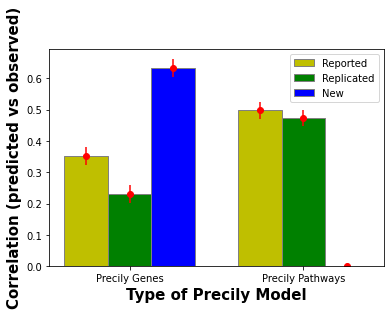

In [1]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(6, 4))
 
# set height of bar
Reported = [0.352, 0.498]
Replicated = [0.231, 0.473]
New = [0.632, 0]
 
# Set position of bar on X axis
br1 = np.arange(len(Reported))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 

# Make the plot
plt.bar(br1, Reported, color ='y', width = barWidth,
        edgecolor ='grey', label ='Reported')
plt.errorbar(br1, Reported, yerr = [0.028, 0.027],fmt="o", color="r")

plt.bar(br2, Replicated, color ='g', width = barWidth,
        edgecolor ='grey', label ='Replicated')
plt.errorbar(br2, Replicated, yerr = [0.028, 0.026],fmt="o", color="r")


plt.bar(br3, New, color ='b', width = barWidth,
        edgecolor ='grey', label ='New')
plt.errorbar(br3, New, yerr = [0.028, 0],fmt="o", color="r")


# Adding Xticks
plt.xlabel('Type of Precily Model', fontweight ='bold', fontsize = 15)
plt.ylabel('Correlation (predicted vs observed)', fontweight ='bold', fontsize = 15)


plt.xticks([r + barWidth for r in range(len(Reported))],
        ['Precily Genes', 'Precily Pathways'])

plt.legend()
plt.show()